# Inhibitory-stabilized rate sequence network

Dynamics:

Excitatory population

$$\tau_E\frac{d\mathbf{h}_E}{dt} = -\mathbf{h}_E + J^{EE}(t)\mathbf{r}_E + J^{EI}\mathbf{r}_I$$

$$\mathbf{r}_E = \phi_E(\mathbf{h}_E)$$

Inhibitory population

$$\tau_I\frac{d\mathbf{h}_I}{dt} = -\mathbf{h}_I + J^{IE}\mathbf{r}_E$$

$$\mathbf{r}_I = \phi_I(\mathbf{h}_I)$$

The I-E weight matrix (to E from I) is a $N_I \times N_E$ matrix of whose elements are all $j_{IE}$.

The E-I weight matrix (to I from E) is a $N_E \times N_I$ matrix of whose elements are all $j_{EI}$.

The E-E weight matrix is chain-structured, with time-dependent weights:

$$J_{x+1, x}^{EE}(t) = J_0(1 + w_xu(t))$$

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from my_stats import get_cmn_p
from disp import set_plot

cc = np.concatenate

DT = .001
N_E = 1000
N_I = 1

RT = np.arange(0, 3., DT)
RX = np.arange(N_E, dtype=float)


def relu(h):
    return np.where(h > 0, h, 0)

def sgm(h):
    return (1 + np.tanh(h))/2

def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1, c_trj='k'):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PuOr', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c=c_trj) for x in xs]
    
    ax.xaxis.tick_bottom()
    ax.set_aspect('auto')
    set_plot(ax, x_label='t', y_label='x')

In [2]:
P_0 = {
    'TAU_E': .05,
    'BETA_E': 10,
    'TH_E': 1,
    
    'TAU_I': .01,
    'BETA_I': 10,
    'TH_I': 1,
    
    'J_IE': 0*np.ones((N_I, N_E)),
    'J_EI': 0*np.ones((N_E, N_I)),
    'J_0': 1*np.diag(np.ones(N_E-1), -1),
}


def smlt(t, w, u_fn, p, h_e_0=None, h_i_0=None):
    
    w_mat = np.diag(w[:-1], -1)
    TAU_E = p['TAU_E']
    TAU_I = p['TAU_I']
    
    phi_e = lambda h: sgm(p['BETA_E']*(h - p['TH_E']))
    phi_i = lambda h: sgm(p['BETA_I']*(h - p['TH_I']))
    # phi_i = lambda h: np.exp(p['BETA_I']*(h - p['TH_I']))
    
    J_IE = p['J_IE']
    J_EI = p['J_EI']
    J_0 = p['J_0']
    
    h_es = np.nan*np.zeros((len(t), N_E))
    h_es[0, :] = h_e_0 if h_e_0 is not None else 0
    
    r_es = np.nan*np.zeros((len(t), N_E))
    r_es[0, :] = phi_e(h_es[0, :])
    
    h_is = np.nan*np.zeros((len(t), N_I))
    h_is[0, :] = h_i_0 if h_i_0 is not None else 0
    
    r_is = np.nan*np.zeros((len(t), N_I))
    r_is[0, :] = phi_i(h_is[0, :])
    
    u = np.nan*np.zeros(len(t))
    u[0] = u_fn(t[0])

    for ct, t_ in enumerate(t[1:], 1):
        
        u_ = u_fn(t_)
        u[ct] = u_
        
        J_EE = J_0*(1 + w_mat*u_)
        
        dh_e = (DT/TAU_E)*(-h_es[ct-1, :] + J_EE@r_es[ct-1, :] + J_EI@r_is[ct-1, :])
        
        h_es[ct, :] = h_es[ct-1, :] + dh_e
        r_es[ct, :] = phi_e(h_es[ct, :])
        
        dh_i = (DT/TAU_I)*(-h_is[ct-1, :] + J_IE@r_es[ct-1, :])
        
        h_is[ct, :] = h_is[ct-1, :] + dh_i
        r_is[ct, :] = phi_i(h_is[ct, :])
        
    return r_es, r_is, h_es, h_is, u

In [9]:
U_FN = lambda t_: 0
W = 0*np.ones(N_E)
INH_OFF = 30
t = np.arange(0, 2, DT)

p = P_0.copy()
# J_0           # exc feed-fwd chain                 # backwards inhibition
p['J_0'] = 4*np.diag(np.ones(N_E-1), -1) - 100*np.diag(np.ones(N_E-INH_OFF), INH_OFF)
p['J_IE'] = 0*np.ones((N_I, N_E))/N_E
p['J_EI'] = 0*np.ones((N_E, N_I))

h_e_0 = 20*np.eye(N_E)[10, :]
r_es, r_is, h_es, h_is, u = smlt(t, W, U_FN, p=p, h_e_0=h_e_0)

# estimate position by weighting nrn idxs w activity
x = (r_es / r_es.sum(axis=1)[:, None])@RX

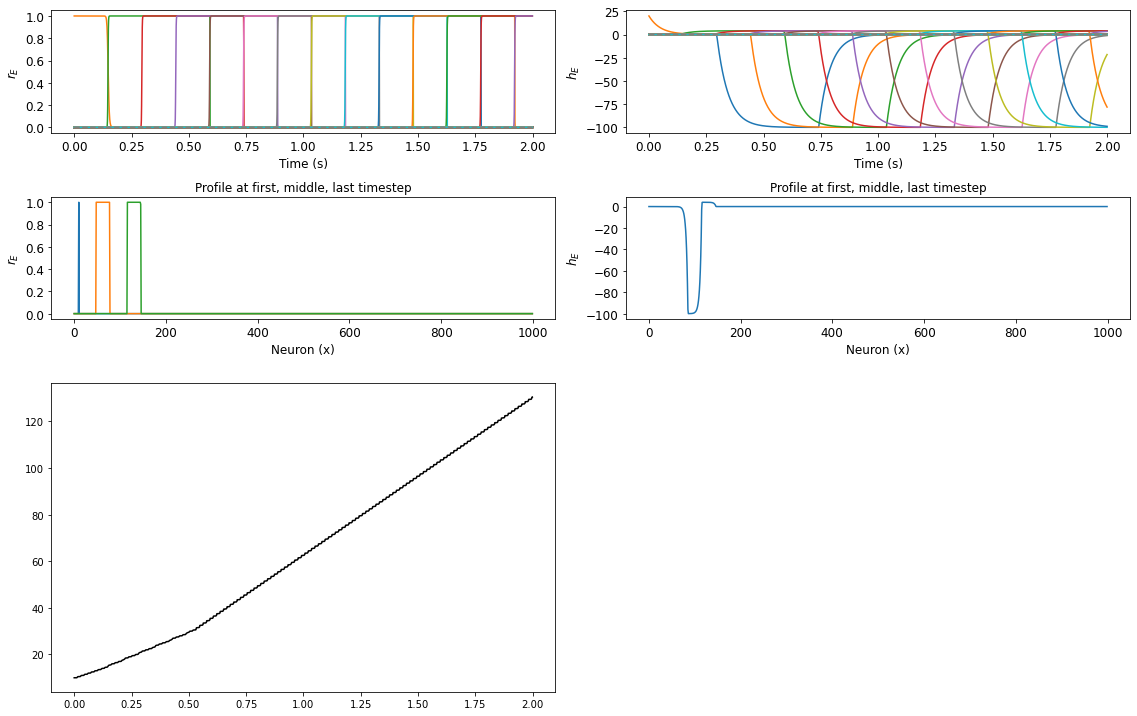

In [10]:
PLOT_EVERY = 10
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(16, 10), tight_layout=True)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2:, 0]),
]
axs[0].plot(t, r_es[:, ::PLOT_EVERY])
axs[0].plot(t, r_is, c='gray', ls='--')
set_plot(axs[0], x_label='Time (s)', y_label=r'$r_E$')

axs[1].plot(RX, r_es[[1, len(t)//2, -1], :].T)
set_plot(axs[1], x_label='Neuron (x)', y_label=r'$r_E$', title='Profile at first, middle, last timestep')

axs[4].plot(t, x, c='k')

axs[2].plot(t, h_es[:, ::PLOT_EVERY])
axs[2].plot(t, h_is, c='gray', ls='--')
set_plot(axs[2], x_label='Time (s)', y_label=r'$h_E$')

axs[3].plot(RX, h_es[-1, :])
set_plot(axs[3], x_label='Neuron (x)', y_label=r'$h_E$', title='Profile at first, middle, last timestep')